# 2018-10-22 Driving V1 membrane potential with filters' levels
Hopefully this is the last notebook where we're using filters, as this short detour was actually a scenic road that took me 10 days.

Now we're using the filters responses as direct current based drivers of the V1. The spiking bin method is removing the temporality due to its probabilistic nature, so direct current variation is preferable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def find_middle(a_list):
    middle = len(a_list)/2
    return a_list[int(middle)]

# Filtres

In [2]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

In [3]:
def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0.001, gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss

# 4x4 ON field simulation
Matplotlib is fucking awful for 3D plots so more than that is unreadable

In [4]:
############
# Constants
############
total_time = 200
filter_size = 3. #c'est plus proche de la vrai valeur d'angle visuel ? Demander à Laurent
filter_res = .1

coo_min, coo_max = 40,60
grid_res = 5

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res, coo_min:coo_max:grid_res].reshape(2,-1).T

#############
# Stim, normalized with total_time/100 for a linear movement
#############
stimuli = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/(total_time/100))) ** 2
        japanese_flag = (circle < 100)
        stimuli.append(japanese_flag)

###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)

Making filters: 100%|██████████| 16/16 [00:00<00:00, 19.30it/s]


Calculating receptor field #0
Calculating receptor field #1
Calculating receptor field #2
Calculating receptor field #3
Calculating receptor field #4
Calculating receptor field #5
Calculating receptor field #6
Calculating receptor field #7
Calculating receptor field #8
Calculating receptor field #9
Calculating receptor field #10
Calculating receptor field #11
Calculating receptor field #12
Calculating receptor field #13
Calculating receptor field #14
Calculating receptor field #15


Text(0.5,0.99,'Multiple RF response from a maximal intensity stimulus\nmoving from [50;0] to [50;100]')

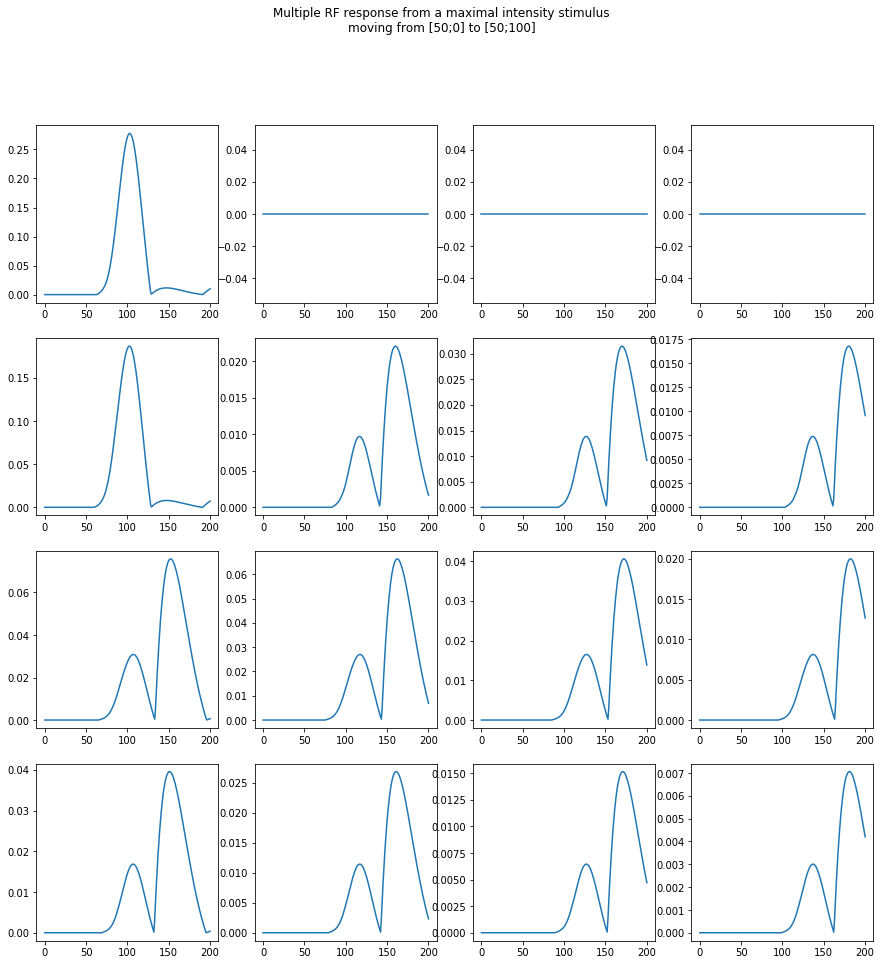

In [5]:
plt.figure(figsize=(15, 15))

st_levels = []
for ft in range(len(st_list)):
    print('Calculating receptor field #%s'%ft)
    ax = plt.subplot(4, 4,ft+1)
    st_level = []
    for i in range(len(stimuli)):
        st_level.append(np.max(st_list[ft][:,:,i]))
    ax.plot(st_level)
    #ax.text(200, .45, "X,Y (°) :%s" % str(filters_coordinates[ft]-40))
    st_levels.append(st_level)
    
#plt.tight_layout()
plt.suptitle(
    "Multiple RF response from a maximal intensity stimulus\nmoving from [50;0] to [50;100]", x=.5, y=.99)


In [6]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.6/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DictError in SLIInterpreter::execute: Key '/Install' does not exist in dictionary.
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [7]:
def VanillaRasterPlot( SpikesP, SpikesE, spike_thresh,injections, title = 'Title', markersize = .5, 
                         figsize = (9,6), shifts = None):
    
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
        
        fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = figsize)
        
        color=iter(plt.cm.gist_heat(np.linspace(.5,.8, 20)))
        for traces in injections:
            axs[0].plot(traces.get_data(), color = next(color))
        axs[0].set_ylabel('I (nA)')
        axs[0].set_title('4x4 LGN filters input')
        axs[0].set_xticklabels([])
        
        axs[1].plot(SpikesE.analogsignals[0].times, SpikesE.analogsignals[0])
        axs[1].set_ylabel('Voltage')
        axs[1].set_title('V1 neuron with alpha-function dynamics ')
        #axs[1].set_xticklabels([0,0,25,50,75,100])
        
        
        plt.xlabel('Time (ms)')
        
        return fig, axs
        
        
def spike_chunk_detector(signal, threshold, timeframe, verbose = False):
    '''
    On a given analogsignal array, detects pseudo-spikes by clustering above-threshold times
    into groups, given a timeframe(ms) and a threshold(mV)
    
    Ideal timeframes are approx. that of the oscillation period of the network
    '''
    
    #working lists
    chunking_list = []
    chunk_list = []
    
    trues = (signal>threshold)
    
    for it, a in enumerate(trues):
        if a == True : 
            #print(post_v.analogsignals[0].times[it])
            chunking_list.append(sig.times[it])
            
    chunking_list = np.squeeze(chunking_list)
    for it, a in enumerate(chunking_list):
        if it > 5 and chunking_list[it-1]+timeframe < chunking_list[it]: #discard first few hits to be safe on initialisation nois
            chunk_list.append(chunking_list[it-1])
            if verbose : print('Found cluster at %s ms' % chunking_list[it-1])
                
    if verbose : print('Found total of %s cluster(s)' % len(chunk_list))
    return chunk_list

Detector found 0 clusters
Simulation done in 3.20 s


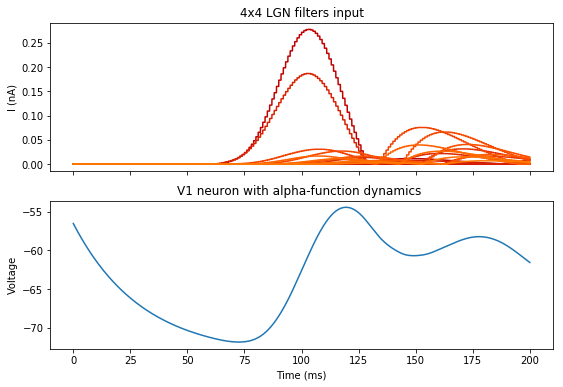

In [8]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(st_levels[0][::injection_sampling_rate]))
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")



for inputs in range(len(st_levels)):
    '''current_times = np.linspace(0, len(st_levels[inputs][::injection_sampling_rate]),
                                len(st_levels[inputs][::injection_sampling_rate]))
    '''
    current_levels = st_levels[inputs][::injection_sampling_rate]
    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v = post.get_data().segments[0]
sig = post_v.analogsignals[0]

clusters = spike_chunk_detector(signal = sig, threshold = -56.5, timeframe = 5, verbose = False)
print('Detector found %s clusters' % len(clusters))

markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

then = time.time()
print('Simulation done in %.2f s' % (then-now))
fig.savefig('./figs/2018_10_23_Filters_to_V1_amps.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')